In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import cv2
import imghdr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

C:\Users\OMKAR JHA\AppData\Local\Temp\ipykernel_10816\3448920550.py:7: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [2]:
data_path = 'D:\Study\Deep Learning Lab\data'  # Update this path
data = tf.keras.utils.image_dataset_from_directory(
    data_path,
    labels='inferred',  # This will create labels based on folder names
    label_mode='categorical',  # Changed from 'int' to 'categorical' for multi-class
    batch_size=32,
    image_size=(256, 256)
)

Found 1985 files belonging to 3 classes.


In [3]:
# Check class names
class_names = data.class_names
print("Class names:", class_names)
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")

Class names: ['Cat', 'Dog', 'humans']
Number of classes: 3


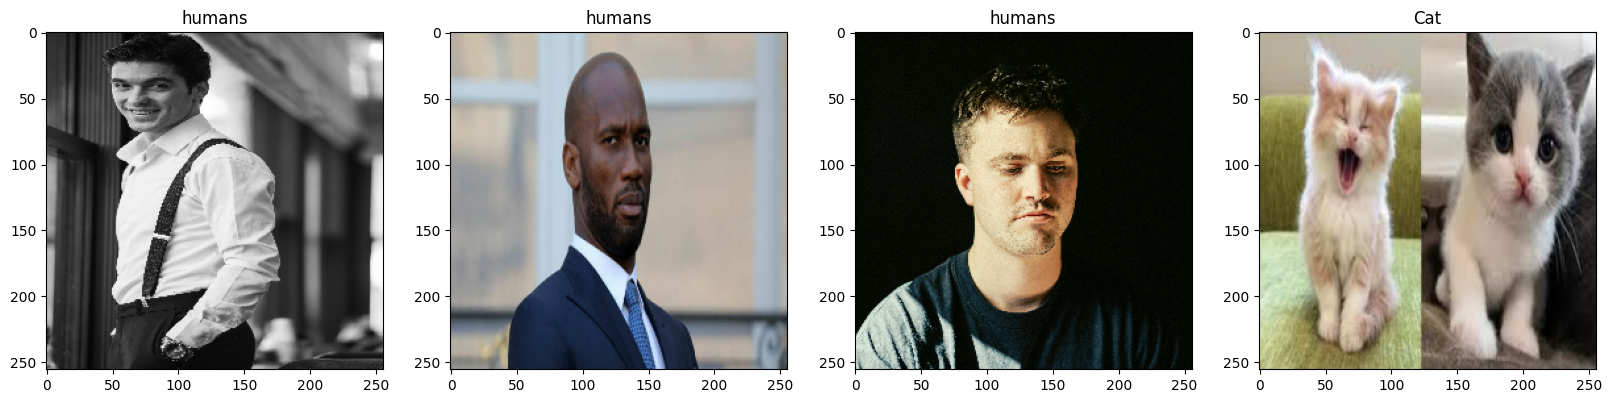

In [4]:
# Visualize some samples
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20, 5))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    # Get the class name from the one-hot encoded label
    class_idx = np.argmax(batch[1][idx])
    ax[idx].title.set_text(class_names[class_idx])

In [5]:
# Normalize pixel values
data = data.map(lambda x, y: (x/255, y))

# Split data
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1)

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

print(f"Train size: {train_size}")
print(f"Validation size: {val_size}")
print(f"Test size: {test_size}")

Train size: 44
Validation size: 12
Test size: 6


In [6]:
#Build the model - Modified for multi-class classification
model = Sequential([
    Conv2D(32, (3, 3), 1, activation='relu', padding='same', input_shape=(256, 256, 3)),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    
    Conv2D(64, (3, 3), 1, activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    
    Conv2D(128, (3, 3), 1, activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    
    Conv2D(128, (3, 3), 1, activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    
    Flatten(),
    Dropout(0.5),  # Added dropout for regularization
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')  # Changed to softmax for multi-class
])

C:\Users\OMKAR JHA\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# Compile model - Updated for multi-class classification
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Changed from BinaryCrossentropy
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,150,659 (65.42 MB)

 Trainable params: 17,150,659 (65.42 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Set up callbacks
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# Early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [9]:
# Train the model
hist = model.fit(
    train,
    epochs=30,
    validation_data=val,
    callbacks=[tensorboard_callback, early_stopping]
)

print("Training completed!")
print(f"Best validation accuracy: {max(hist.history['val_accuracy']):.4f}")

Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 227s 5s/step - accuracy: 0.4368 - loss: 1.1725 - val_accuracy: 0.5312 - val_loss: 0.8994
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 206s 5s/step - accuracy: 0.5430 - loss: 0.8922 - val_accuracy: 0.6250 - val_loss: 0.7803
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 176s 4s/step - accuracy: 0.6372 - loss: 0.7844 - val_accuracy: 0.6823 - val_loss: 0.7441
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 211s 5s/step - accuracy: 0.6550 - loss: 0.6995 - val_accuracy: 0.7240 - val_loss: 0.6375
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 262s 5s/step - accuracy: 0.6941 - loss: 0.6460 - val_accuracy: 0.7630 - val_loss: 0.5620
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 228s 5s/step - accuracy: 0.7821 - loss: 0.5372 - val_accuracy: 0.7943 - val_loss: 0.5016
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 212s 5s/step - accuracy: 0.8244 - loss: 0.4265 - val_accuracy: 0.7604 - val_loss: 0.6131
Epoch 8/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 207s 5s/step - accuracy: 0.8049 - loss: 0.4618 - val_accuracy: 0.7969 - v

In [11]:
# Loss plot
ax1.plot(hist.history['loss'], color='teal', label='Training Loss')
ax1.plot(hist.history['val_loss'], color='orange', label='Validation Loss')
ax1.set_title('Model Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')
ax1.legend()

In [12]:
# Accuracy plot
ax2.plot(hist.history['accuracy'], color='teal', label='Training Accuracy')
ax2.plot(hist.history['val_accuracy'], color='orange', label='Validation Accuracy')
ax2.set_title('Model Accuracy')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Epoch')
ax2.legend()

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [13]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8177


In [14]:
# Detailed evaluation
y_true = []
y_pred = []

for batch in test.as_numpy_iterator():
    X, y = batch
    predictions = model.predict(X, verbose=0)
    
    # Convert one-hot to class indices
    y_true.extend(np.argmax(y, axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

In [15]:
# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

         Cat       0.71      0.70      0.70        53
         Dog       0.69      0.74      0.72        58
      humans       0.96      0.93      0.94        81

    accuracy                           0.81       192
   macro avg       0.79      0.79      0.79       192
weighted avg       0.81      0.81      0.81       192



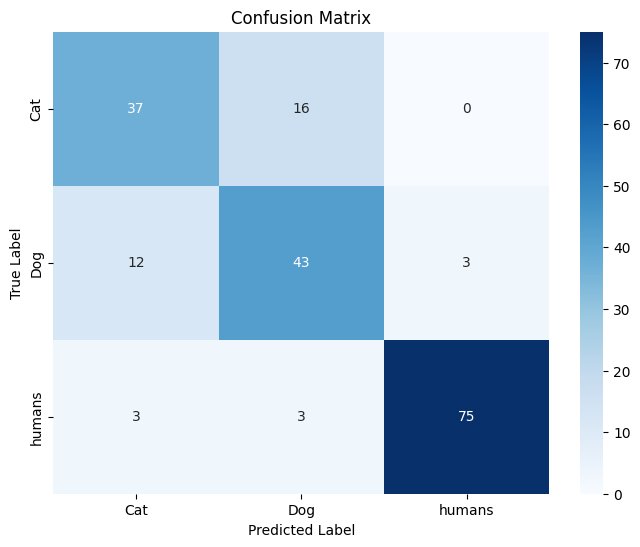

In [16]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [7]:
# Function to predict single image
def predict_image(image_path, model, class_names):
    """
    Predict the class of a single image
    """
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    
    # Display original image
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')
    
    # Resize and normalize
    img_resized = tf.image.resize(img, (256, 256))
    plt.subplot(1, 2, 2)
    plt.imshow(img_resized.numpy().astype(int))
    plt.title('Resized Image')
    plt.axis('off')
    plt.show()
    
    # Make prediction
    img_array = np.expand_dims(img_resized/255, 0)
    predictions = model.predict(img_array, verbose=0)
    
    # Get prediction results
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx]
    predicted_class = class_names[predicted_class_idx]
    
    print(f"Predicted class: {predicted_class}")
    print(f"Confidence: {confidence:.4f}")
    
    # Show all class probabilities
    print("\nAll class probabilities:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: {predictions[0][i]:.4f}")
    
    return predicted_class, confidence

In [ ]:
# Example usage (update with your test image path)
# predicted_class, confidence = predict_image('/path/to/test/image.jpg', model, class_names)

# Save the model
model.save('dog_cat_human_classifier.h5')
print("Model saved as 'dog_cat_human_classifier.h5'")

# Function to load and use the saved model
def load_and_predict(model_path, image_path, class_names):
    """
    Load a saved model and make predictions
    """
    loaded_model = tf.keras.models.load_model(model_path)
    return predict_image(image_path, loaded_model, class_names)

Model saved as 'dog_cat_human_classifier.h5'


In [17]:
# Test a single image provided by user
def test_user_image():
    """
    Ask user for image path and test it
    """
    print("\n🖼️  IMAGE TESTING")
    print("=" * 30)
    
    # Define class names (update these to match your dataset folder names)
    class_names = ['cats', 'dogs', 'humans']  # Change these if your folders have different names
    
    # Load the saved model
    try:
        print("🔄 Loading saved model...")
        loaded_model = tf.keras.models.load_model('dog_cat_human_classifier.h5')
        print("✅ Model loaded successfully!")
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        print("Make sure 'dog_cat_human_classifier.h5' exists in your current directory.")
        return
    
    # Get image path from user
    image_path = input("Enter the path to your image: ").strip().replace('"', '')
    
    # Check if file exists
    if not os.path.exists(image_path):
        print("❌ Image file not found! Please check the path.")
        return
    
    print(f"🔍 Testing image: {os.path.basename(image_path)}")
    
    # Use your existing predict_image function with loaded model
    try:
        predicted_class, confidence = predict_image(image_path, loaded_model, class_names)
        
        # Additional summary
        print(f"\n✅ RESULT: {predicted_class.upper()} (Confidence: {confidence:.1%})")
        
    except Exception as e:
        print(f"❌ Error testing image: {e}")


🖼️  IMAGE TESTING
🔄 Loading saved model...


✅ Model loaded successfully!
🔍 Testing image: cat_test.jpg


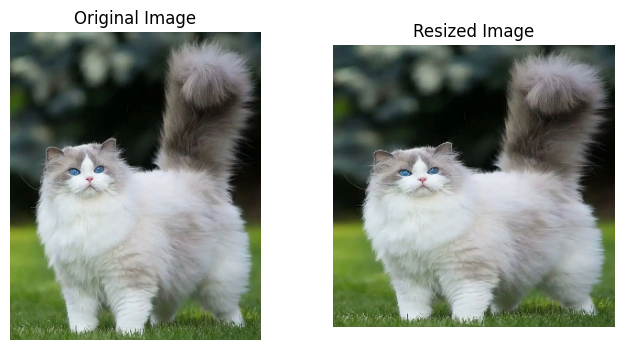

Predicted class: dogs
Confidence: 0.9293

All class probabilities:
cats: 0.0653
dogs: 0.9293
humans: 0.0053

✅ RESULT: DOGS (Confidence: 92.9%)


In [22]:
# Run the test
test_user_image()